# Roman Urdu Sentiment Analysis 

### Background
A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks
about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist
for sentiment analysis, however, they need help with under-resourced languages.

### Summary
The dataset used for sentiment classification contains text messages which are a combination of Urdu and English. For example, "Je Thik Kaha Right" meaning "You said it right". This dataset comes with many challenges like spelling errors, unclear grammatical structure and out of vocabulary words. Also words in Urdu have multiple variations when written in English which leads to large amount of sparse tokens. For instance, "pyaar" meaning love can be written as "piyar", "peyar","pyar" etc. All of these issues can impact the accuracy of the model.

To address some of the above problems we create our own list of stopwords in addition to English stopwords provided by NLTK library. We also use character n-grams to create TF-IDF vectors, character n-grams are especially powerful at detecting patterns in such misspellings, and are substantially less sparse than word n-grams.We will discuss how these challenges can be further addressed later in **'Next Steps'**.

**Approach :**
We first preprocess the text messages by lower-casing the text and removing punctuations and stopwords from the messages. We then generate char 3-grams, 4-grams and 5-grams vectors from the sentences and feed them to different classifiers (Multinomial Naive Bayes, Support Vector Machines, Random Forests) to classify the sentiment of the sentence. Since for this particular problem predicting Negative classes accurately is of importance, the model which gives highest F1-Score (0.63) and Recall Rate (0.59) for Negative class as well as good overall accuracy (65.8%) and F1 score (0.65) is selected. We thus use Support Vector Machines to identify the sentiment (Positive,Negative,Neutral) of Roman Urdu text messages for this dataset. Also, this dataset has imbalanced classes so Random Undersampling of majority classes is performed to balance the class distribution of the dataset.



In [39]:
import pandas as pd
import numpy as np
import emoji
from emoji import UNICODE_EMOJI
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  StratifiedKFold 
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing and Cleaning

In [2]:
data = pd.read_csv('/storage/data/Roman Urdu DataSet.csv',header=None)
data.columns = ['text','sentiment','extra']
data['text'] = data['text'].astype(str)
data['sentiment'] = data['sentiment'].astype(str)


In [3]:
data.head()

,text,sentiment,extra
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


In [4]:
data.describe()

,text,sentiment,extra
count,20229,20229,7
unique,19665,4,6
top,Good,Neutral,till here
freq,23,8929,2


In [5]:
#drop identical rows from the dataset
print(data.shape)
data['text'] = data['text'].str.strip()
data['sentiment'] = data['sentiment'].str.strip()
data = data.drop_duplicates()
print(data.shape)

(20229, 3)
(19615, 3)


In [6]:
#Check values for rows that are not null in the 'extra' column
data[~data.extra.isnull()]

,text,sentiment,extra
13637,movie abi b baki h,Neutral,----------------
13653,Hahahahahaha bilkul sahi,Neutral,----------
14218,tjhe ase mar na chahti hun tjhe nae tu achi bachi hy,Negative,-------
14810,Yr tym pta chali kb ata raat m?,Positive,------
17161,Kya khatab g ledy type ka sahafi la k betha diya,Negative,9090
19499,kabhi bhai ki bhi aesi pic lele :P,Neutral,till here
19780,"Jahil awam ko jahil leader ki hi zroorat hai, yeh Aunty bachon ko parhney k liye school nh pyari pyari sarkoon pr bhejey gi :D Nawaz sharif to 3 3 mahiney london rehta hai sarkein kya khaak banaye ga",Negative,till here


In [7]:
#Drop 'extra' column as it contains jargon that will be of no use to our model
data = data.drop('extra',axis=1)
data = data.reset_index(drop=True)

In [8]:
data.sentiment.value_counts()

Neutral     8525
Positive    5846
Negative    5243
Neative        1
Name: sentiment, dtype: int64

In [9]:
data[data.sentiment == 'Neative']

,text,sentiment
12746,product achi hai but wrong waist size send kar diya.,Neative


In [10]:
#There is one row with sentiment 'Neative', this looks like a typo and should be replaced with 'Negative'
data['sentiment'] = np.where(data.sentiment == 'Neative','Negative',data.sentiment)
print(data.shape)
data.sentiment.value_counts()

(19615, 2)


Neutral     8525
Positive    5846
Negative    5244
Name: sentiment, dtype: int64

In [11]:
#These text messages have emojis in the messages, the following function counts the number of emojis in each message
def count_emoji(text):
    """
      text: each input string
    """
    count = sum([1 for char in str(text) if char in UNICODE_EMOJI])
    return count

data['emoji_count'] = data['text'].apply(lambda x: count_emoji(x))

In [12]:
data[data.emoji_count > 0].sentiment.value_counts()

Neutral     758
Negative    239
Positive    187
Name: sentiment, dtype: int64

In [13]:
data['len_text'] = data['text'].apply(lambda x : len(x))
data.head()

,text,sentiment,emoji_count,len_text
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,0,97
1,sahi bt h,Positive,0,9
2,"Kya bt hai,",Positive,0,11
3,Wah je wah,Positive,0,10
4,Are wha kaya bat hai,Positive,0,20


In [14]:
#Check for missing data
data[(data.len_text==0) | (data.text=='') | (data.text.isnull())]

,text,sentiment,emoji_count,len_text
7802,,Neutral,0,0


In [15]:
data.describe()

,emoji_count,len_text
count,19615.000000,19615.000000
mean,0.137344,68.974152
std,0.651766,70.874119
min,0.000000,0.000000
25%,0.000000,27.000000
50%,0.000000,47.000000
75%,0.000000,89.000000
max,11.000000,2017.000000


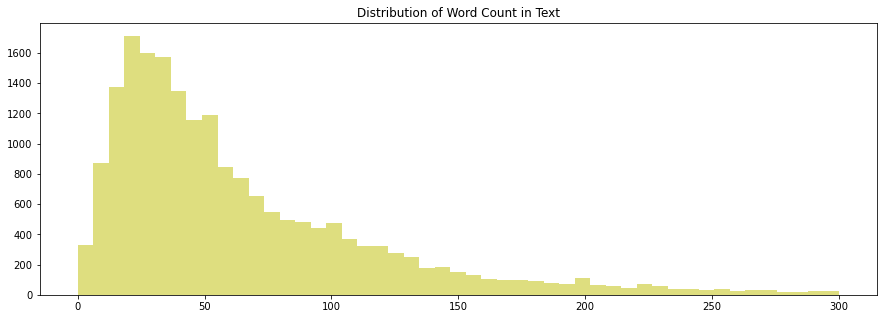

In [16]:
#Distribution of word count 
bins = np.linspace(0, 300, 50)
kwargs = dict(alpha=0.5, bins=bins)
plt.figure(figsize=(15, 5))
plt.hist(data['len_text'], **kwargs,color='y')
plt.title('Distribution of Word Count in Text')
plt.show()

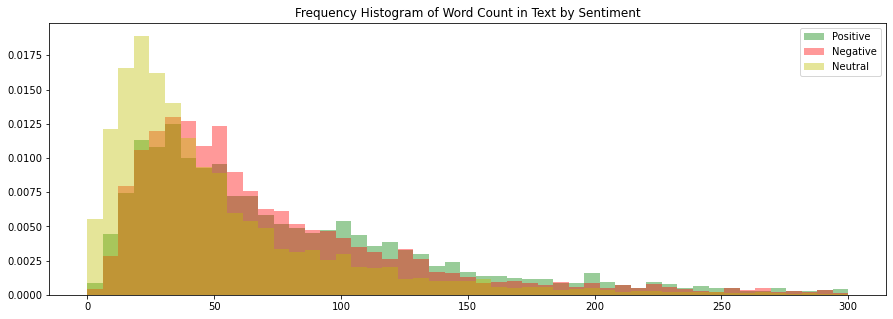

In [17]:
#Distribution of word count by each sentiment
positive = data.loc[data.sentiment == 'Positive','len_text']
negative = data.loc[data.sentiment == 'Negative','len_text']
neutral = data.loc[data.sentiment == 'Neutral','len_text']
kwargs = dict(alpha=0.4, bins=bins,density=True)
plt.figure(figsize=(15, 5))
plt.hist(positive, **kwargs, color='g', label='Positive')
plt.hist(negative, **kwargs, color='r', label='Negative')
plt.hist(neutral, **kwargs, color='y', label='Neutral')

plt.gca().set(title='Frequency Histogram of Word Count in Text by Sentiment')

plt.legend();

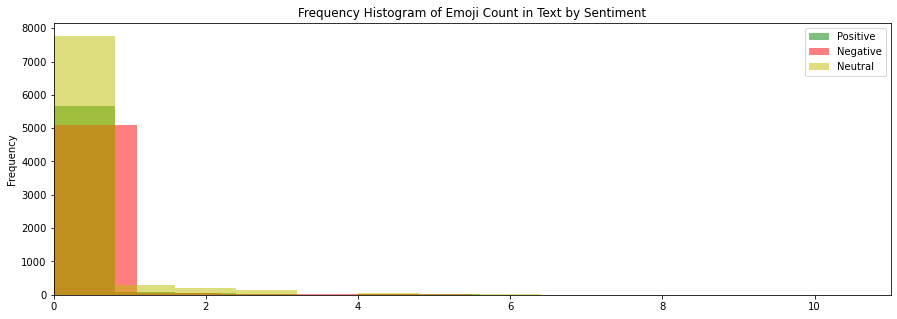

In [18]:
#Distribution of emoji count by each sentiment
positive = data.loc[data.sentiment == 'Positive','emoji_count']
negative = data.loc[data.sentiment == 'Negative','emoji_count']
neutral = data.loc[data.sentiment == 'Neutral','emoji_count']
kwargs = dict(alpha=0.5, bins=10)
plt.figure(figsize=(15, 5))
plt.hist(positive, **kwargs, color='g', label='Positive')
plt.hist(negative, **kwargs, color='r', label='Negative')
plt.hist(neutral, **kwargs, color='y', label='Neutral')

plt.gca().set(title='Frequency Histogram of Emoji Count in Text by Sentiment', ylabel='Frequency')
plt.xlim(0,11)
plt.legend();

In [19]:
#Clean the text data - remove punctuations
def preprocessing_text(text):
    """
      text: each input string
    """
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split()]
    return " ".join(text)

In [20]:
data['clean_text'] = data.text.apply(preprocessing_text)

In [21]:
data.head()

,text,sentiment,emoji_count,len_text,clean_text
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,0,97,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus
1,sahi bt h,Positive,0,9,sahi bt h
2,"Kya bt hai,",Positive,0,11,Kya bt hai
3,Wah je wah,Positive,0,10,Wah je wah
4,Are wha kaya bat hai,Positive,0,20,Are wha kaya bat hai


As part of data cleaning, we need to remove the stop words too but this text is not entirely in English. We can't use the existing stopword list from nltk library as it does not support this langauge, so the 'English' list needs to be enhanced using the corpus of words created from this dataset.

In [22]:
#Identify 50 most common words in the corpus
def common_words_corpus(data):
    words_list = ' '.join([i.lower() for i in data]).split()
    print("Total words in corpus : ",len(words_list))
    freqDist = FreqDist(words_list)
    print("Total unique words in corpus : ",len(freqDist.keys()))
    print("Fifty most used words in the corpus")
    plt.figure(figsize=(15, 5))
    freqDist.plot(50)
    

Total words in corpus :  263491
Total unique words in corpus :  34215
Fifty most used words in the corpus


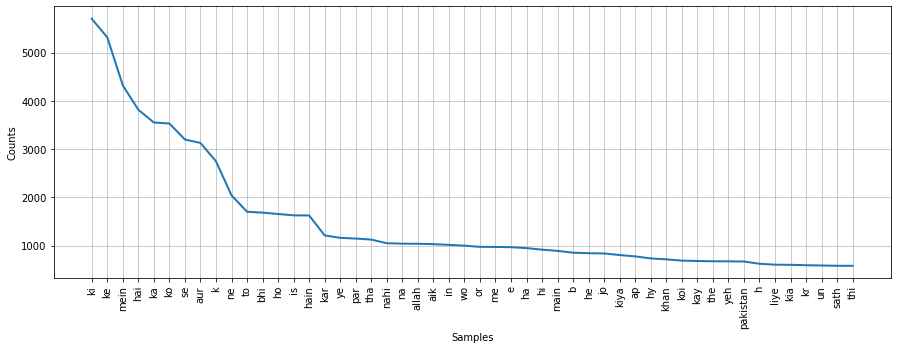

In [23]:
#Identify most common words in the corpus
common_words_corpus(data['clean_text'])


Total words in corpus :  95122
Total unique words in corpus :  16229
Fifty most used words in the corpus


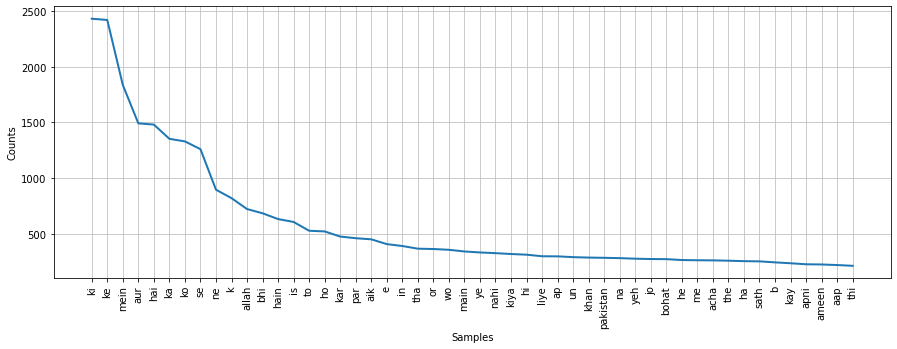

In [24]:
#Identify most common words in texts with Positive Sentiment
common_words_corpus(data.loc[data.sentiment == 'Positive','clean_text'])

Total words in corpus :  80581
Total unique words in corpus :  16525
Fifty most used words in the corpus


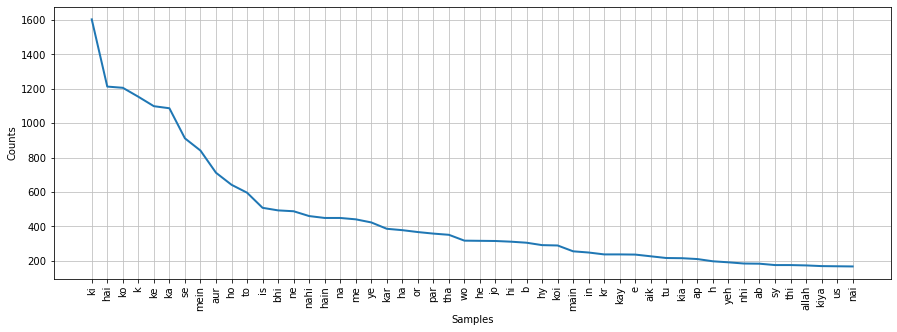

In [25]:
#Identify most common words in texts with Negative Sentiment
common_words_corpus(data.loc[data.sentiment == 'Negative','clean_text'])

Total words in corpus :  87788
Total unique words in corpus :  17163
Fifty most used words in the corpus


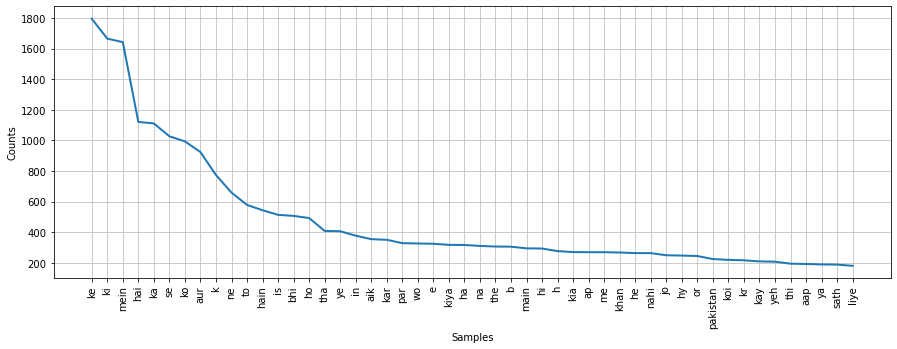

In [26]:
#Identify most common words in texts with Neutral Sentiment
common_words_corpus(data.loc[data.sentiment == 'Neutral','clean_text'])

There is some overlap between the most commonly used words in the text for all three sentiment types. We include those words to our stopword list.

In [27]:
urdu_stopwords = ['ke','ki','mein','hai','ka','aur','ko','se','k','to','ne','bhi','hain','is','ho','kar','par',
                  'wo','ye','b','e','hi','ha','tha','main','h','jo','liye','yeh','lekin', 'lakin', 'kitna', 'ke',
                  'hota', 'hon', 'kab', 'kb', 'kabhi', 'sirf', 'hoti', 'hote', 'magar', 'app', 'agar', 'agr',
                  'hun', 'hu', 'rha', 'raha', 'ja', 'rahay']

In [28]:
stopwords_list = stopwords.words('english')
#stopwords_list.extend(urdu_stopwords)

In [29]:
#Remove stopwords from text
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stopwords_list]
    return " ".join(text)

In [30]:
data['clean_text'] = data['clean_text'].apply(lambda x : remove_stopwords(x) )

In [31]:
#Checking for missing values after preprocessing text
print("Number of rows with missing text:",len(data[data['clean_text']=='']))
data[data['clean_text']==''].sentiment.value_counts()

Number of rows with missing text: 64


Neutral     63
Negative     1
Name: sentiment, dtype: int64

In [32]:
data[(data['clean_text']=='')].head()

,text,sentiment,emoji_count,len_text,clean_text
4547,you too,Neutral,0,7,
4603,:D,Neutral,0,2,
4736,What is this,Neutral,0,12,
4788,what??,Neutral,0,6,
5024,It's me,Neutral,0,7,


In [33]:
#Drop rows with missing text
data = data[data.clean_text!='']
data = data.reset_index(drop=True)
print(data.shape)

(19551, 5)


In [50]:
#Remove duplicate rows after text cleaning
df = data[['clean_text','sentiment']]
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print(df.shape)

(19416, 2)


# Convert Text to Vectors
Sentiment Classifier can not directly classify text and thus text needs to be converted into vectors. We take character 3-grams, 4-grams and 5-grams while ignoring n-grams with document frequency less than 2 to create TF-IDF vectors. Character n-grams are especially powerful at detecting patterns in texts with misspellings, and are substantially less sparse than word n-grams.

In [51]:
vectorizer = TfidfVectorizer(analyzer = 'char',ngram_range=(3,5),min_df=2)
vectors = vectorizer.fit_transform(df['clean_text'])
vectors.shape

(19416, 134677)

# Classification Model
We split the dataset into Test and Train keeping same proportion of class labels. However, this dataset has imbalanced classes with 43% texts with 'Neutral Sentiment', 30% texts with 'Positive Sentiment' and remaining 27% text with 'Negative Sentiment'. Therefore, accuracy alone can not be used to evaluate the overall performance of a classifier as it will not properly account for the performances of each class here because of the skewed distribution of class labels. Hence, we also use F1 score (Harmonic Mean of Precision and Recall) for each class. Also, to handle class imbalance in the dataset, we perform random undersampling of majority class. A character n-gram based SVM model is used to predict the sentiment of Roman Urdu text messages.

* Independent Variable : Character TF-IDF Feature Vector Matrix
* Dependent Variable: Sentiment




In [52]:
#Splitting data in train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(vectors, df['sentiment'], stratify= df['sentiment'],test_size=0.2, random_state=10)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(15532, 134677)
(3884, 134677)
(15532,)
(3884,)


In [53]:
#Random undersampling of majority class on train data
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print(X_train.shape,y_train.shape)

(12579, 134677) (12579,)


In [62]:
#Perform K-Fold cross validation for model selection
kfold =  StratifiedKFold(n_splits=5, random_state=100,shuffle=True)
svm = LinearSVC(C=0.5)
print("Accuracy for SVM Validation:",np.mean(cross_val_score(svm, X_train, y_train, cv=kfold, scoring='accuracy')))
mnb = MultinomialNB(alpha=0.25)
print("Accuracy for MNB Validation:",np.mean(cross_val_score(mnb, X_train, y_train, cv=kfold, scoring='accuracy')))
rfc = RandomForestClassifier(n_estimators=100,  random_state=111)
print("Accuracy for RF Validation:",np.mean(cross_val_score(rfc, X_train, y_train, cv=kfold, scoring='accuracy')))

Accuracy for SVM Validation: 0.6355035131026243
Accuracy for MNB Validation: 0.606486992196266
Accuracy for RF Validation: 0.6089502729252467


In [63]:
#Using Support Vector Machines (model with highest accuracy) to predict on Test Data
svm.fit(X_train, y_train)
print ("Accuracy for Test: " ,  (accuracy_score(y_test, svm.predict(X_test))))
print(classification_report(svm.predict(X_test),y_test))

Accuracy for Test:  0.6583419155509783
              precision    recall  f1-score   support

    Negative       0.67      0.59      0.63      1185
     Neutral       0.65      0.70      0.67      1545
    Positive       0.67      0.67      0.67      1154

    accuracy                           0.66      3884
   macro avg       0.66      0.65      0.66      3884
weighted avg       0.66      0.66      0.66      3884



In [64]:
#Classifying Sentiment on Sample Data using the model
text = "Woh to MASHA'ALLAH se meri qabliat Hai.. "
text = preprocessing_text(text)
text = remove_stopwords(text)
text_vector = vectorizer.transform([text])
print("Sentiment :",(svm.predict(text_vector)))


Sentiment : ['Positive']


# Conclusion
We observe in the training data that some text messages have been classified incorrectly. For instance, the message "Aisaaa hi hai" (meaning "It's like that") has Neutral Sentiment but it has been labelled Positive. So the model learned on this ambiguous data, thus affecting the classification accuracy of test data.    

The proposed model gives an Overall Accuracy of 65.8% and F1-Score of 0.65. This is much higher than the baseline accuracy of 43%. However, when classifying sentiment it is important that negative text messages are reported with higher accuracy. This would help the corporation in identifying pain points of their customers and therefore help in improving customer satisfaction. Thus, the model with hyperparameters that gives highest F1-score (0.63) and Recall (0.59) for negative class as well as good overall accuracy (65.8%) is chosen to classify the sentiment of messages left by customers on social channels. 



# Next Steps
In order to further improve the accuracy of the classification model, we can create a Language Model for Roman Urdu text (or any other under-resourced langauge) that has been trained to guess the next word in the text. To do this we need not feed a labelled dataset to our model but instead just train it on lots of Roman Urdu text. To accurately guess the next word in the sentence, the language model will have to develop an understanding of the language. After that's done, we can use this pretrained Roman Urdu model to fine tune a Language Model that is specific to our corpus (Customer Reviews for a corporation) so that the model can become good at predicting the next word for a customer review. 

Once we have a fine tuned Roman Urdu Language model specific to our corpus, it can be used for Sentiment Classification using Transfer Learning. This approach can give us significantly better predictions.

